In [1]:
import json
from operator import index
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import time

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore', '.*sliced data.*', )

2022-02-25 15:02:56.725910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 15:02:56.725977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def prepare_dataset(path : str, workload_name : str):
    dataset = {}
    files = os.listdir(path)

    for file in files:
        with open(path+"/"+file, "r") as f:
            raw_str = f.read()
        data = json.loads(raw_str)

        if "layers" in data.keys():
            del data["layers"]

        if "relay" in data.keys():
            del data["relay"]

        if "conv2d" in workload_name:
            data["kernel_0"] = data["kernel"][0]
            data["kernel_1"] = data["kernel"][1]
            del data["kernel"]
            data["dilation_0"] = data["dilation"][0]
            data["dilation_1"] = data["dilation"][1]
            del data["dilation"]

            if not "kernel layout" in data.keys():
                data["kernel layout"] = "OIHW"

        elif workload_name == "dense":
            data["features"] = data["input shape"][1]
            del data["input shape"]
            del data["output shape"]
            #print()

        elif workload_name in ["max_pool2d", "avg_pool2d"]:
            data["pool_0"] = data["pool_size"][0]
            data["pool_1"] = data["pool_size"][1]
            del data["pool_size"]

        if workload_name in ["max_pool2d", "avg_pool2d", "conv2d", "dilated_conv2d", "depthwise_conv2d"]:
            del data["padding"]
            data["C_I"] = data["input shape"][3]
            data["H_I"] = data["input shape"][1]
            data["W_I"] = data["input shape"][2]
            del data["input shape"]

            data["C_O"] = data["output shape"][3]
            data["H_O"] = data["output shape"][1]
            data["W_O"] = data["output shape"][2]
            del data["output shape"]

            key = "strides"
            if "stride" in data.keys():
                key = "stride"
            #print(key)
            data["strides_0"] = data[key][0]
            data["strides_1"] = data[key][1]
            del data["strides"]
            if "stride" in data.keys():
                del data["stride"]

        dataset[file] = data

    return dataset

def create_dataframe(dataset : dict, workload_name : str):
    df = pd.DataFrame.from_dict(dataset, orient='index')
    categoricals = [
        "output dtype",
        "compute dtype",
        "workload",
        ]
    if workload_name in ["conv2d", "max_pool2d", "avg_pool2d", "depthwise_conv2d", "dilated_conv2d"]:
        categoricals += [
            #"padding",
            "data layout",
        ]
    if "conv2d" in workload_name:
        categoricals += [
            "kernel layout",
        ]

    for col in categoricals:
        oh = pd.get_dummies(df[col], prefix=col, drop_first=False)
        df = pd.concat([df, oh], axis=1).drop(col, axis=1)
    
    features = list(df.columns)
    labels = ["time", "power", "memory"]
    for label in labels:
        idx = features.index(label)
        del features[idx]
    del idx
    df = df.drop_duplicates(subset=features)

    output = pd.concat([df["time"], df["power"], df["memory"]], axis=1)
    df.pop("time")
    df.pop("power")
    df.pop("memory")

    return df, output

In [4]:
!ls dataset/

 cuda_980ti   cuda_A100   cuda_K80  'llvm -mcpu=haswell_E5-2680'


In [5]:
dataset_base = "./dataset"
targets = os.listdir(dataset_base)

layer_targets = list()
for target in targets:
    target_path = dataset_base + "/" + target
    layers = os.listdir(target_path)
    
    for layer in layers:
        dataset_path = target_path + "/" + layer + "/"
        print(dataset_path)
        layer_targets.append(dataset_path)

print("found {0} folders with samples, going to train models for each of these targets".format(len(layer_targets)))
print()

./dataset/cuda_980ti/avg_pool2d/
./dataset/cuda_980ti/conv2d/
./dataset/cuda_980ti/dense/
./dataset/cuda_980ti/depthwise_conv2d/
./dataset/cuda_980ti/dilated_conv2d/
./dataset/cuda_980ti/max_pool2d/
./dataset/cuda_A100/avg_pool2d/
./dataset/cuda_A100/conv2d/
./dataset/cuda_A100/dense/
./dataset/cuda_A100/depthwise_conv2d/
./dataset/cuda_A100/dilated_conv2d/
./dataset/cuda_A100/max_pool2d/
./dataset/cuda_K80/avg_pool2d/
./dataset/cuda_K80/conv2d/
./dataset/cuda_K80/dense/
./dataset/cuda_K80/depthwise_conv2d/
./dataset/cuda_K80/dilated_conv2d/
./dataset/cuda_K80/max_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/avg_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dense/
./dataset/llvm -mcpu=haswell_E5-2680/depthwise_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dilated_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/max_pool2d/
found 24 folders with samples, going to train models for each of these targets



In [6]:
models = {
    "xgb": xgb.XGBRegressor,
    "ert": ExtraTreesRegressor,
    #"dTr": DecisionTreeRegressor,
    #"liR": LinearRegression,
    #"kNN": KNeighborsRegressor,
    #"SVR": SVR,
    #"MLP": MLPRegressor,
}

kwargs_dict = {
    "xgb": None,
    "ert": {"n_estimators":50},
    "dTr": None,
    "liR": None,
    "kNN": None,
    "SVR": None,
    "MLP": None,
}

results = {}

In [7]:
for target in layer_targets:
    tmp = target.split("/")
    workload_name = tmp[-2]
    device_name = tmp[-3]
    files = os.listdir(target)
    dataset = {}
    
    print("{} : {}\t:\t contains {} samples".format(workload_name, device_name, len(files)))
    dataset = prepare_dataset(target, workload_name)
    #print("\tLoading data into memory:\tcompleted")
    df, output = create_dataframe(dataset, workload_name)
    #print("\tCreating dataframe:\t\tcompleted")
    print("\t[INFO] Remaining Samples after duplicate elimination:\t{}".format(len(df)))
    #print("\t[INFO] Features that are used as predictor inputs   :\n\t\t{}".format(list(df.columns)))
    #print("\t[INFO] Metrics that are going to be predicted       :\n\t\t{}".format(list(output.columns)))
    #print()
    X = df.to_numpy()
    Y = output.to_numpy()
    labels = list(output.columns)

    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    for method, constructor in models.items():
        for idx, name in enumerate(labels):
            print(method)
            if kwargs_dict[method] != None:
                model = constructor(**kwargs_dict[method])
            else:
                model = constructor()
                
            model.fit(X_train, y_train[:,idx])

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            r2_train = r2_score(y_train[:,idx], y_train_pred)
            r2_test = r2_score(y_test[:,idx], y_test_pred)

            mae_train = mean_absolute_error(y_train[:,idx], y_train_pred)
            mae_test = mean_absolute_error(y_test[:,idx], y_test_pred)

            mape_train = mean_absolute_percentage_error(y_train[:,idx], y_train_pred)
            mape_test = mean_absolute_percentage_error(y_test[:,idx], y_test_pred)

            print(name)
            print("\tR2    (train|test):\t{:.5f}\t\t{:.5f}".format(r2_train, r2_test))
            print("\tMAE   (train|test):\t{:.5f}\t\t{:.5f}".format(mae_train, mae_test))
            print("\tMAPE  (train|test):\t{:.5f}\t\t{:.5f}".format(mape_train, mape_test))
            print()
            result = {
                "device" : device_name,
                "workload" : workload_name,
                "metric" : name,
                "predictor" : method,
                "training set size": len(X_train),
                "validation set size": len(X_test),
                "r2_train" : r2_train,
                "r2_test" : r2_test,
                "mae_train" : mae_train,
                "mae_test" : mae_test,
                "mape_train" : mape_train,
                "mape_test" : mape_test,
                "minimum" : Y[:,idx].min(),
                "maximum" : Y[:,idx].max(),
                "mean" : Y[:,idx].mean(),
                "median" : np.median(Y[:,idx]),
            }
            results[device_name+"-"+workload_name+"-"+name+"-"+method] = result

avg_pool2d : cuda_980ti	:	 contains 4692 samples
	[INFO] Remaining Samples after duplicate elimination:	4692
xgb
time
	R2    (train|test):	0.99648		0.94082
	MAE   (train|test):	0.17806		0.60460
	MAPE  (train|test):	0.42969		0.76503

xgb
power
	R2    (train|test):	0.99556		0.96597
	MAE   (train|test):	0.96488		2.24373
	MAPE  (train|test):	0.00597		0.01421

xgb
memory
	R2    (train|test):	0.99726		0.96277
	MAE   (train|test):	0.03585		0.11671
	MAPE  (train|test):	0.06962		0.17032

ert
time
	R2    (train|test):	1.00000		0.91617
	MAE   (train|test):	0.00000		0.59805
	MAPE  (train|test):	0.00000		0.31459

ert
power
	R2    (train|test):	1.00000		0.93087
	MAE   (train|test):	0.00001		2.82022
	MAPE  (train|test):	0.00000		0.01831

ert
memory
	R2    (train|test):	1.00000		0.95929
	MAE   (train|test):	0.00000		0.10432
	MAPE  (train|test):	0.00000		0.11541

conv2d : cuda_980ti	:	 contains 2705 samples
	[INFO] Remaining Samples after duplicate elimination:	2690
xgb
time
	R2    (train|test):	0.9993

In [8]:
date_time = "short_results/results_n50_"+str(int(time.time()))
results = pd.DataFrame.from_dict(results, "index")
results.to_csv(date_time+"-predictor_results.csv")
results.to_excel(date_time+"-predictor_results.xlsx")
results.to_html(date_time+"-predictor_results.html")
results.to_markdown(date_time+"-predictor_results.md")
print("done")

done


In [9]:
results

,device,workload,metric,predictor,training set size,validation set size,r2_train,r2_test,mae_train,mae_test,mape_train,mape_test,minimum,maximum,mean,median
cuda_980ti-avg_pool2d-time-xgb,cuda_980ti,avg_pool2d,time,xgb,3753,939,0.996477,0.940820,1.780598e-01,6.046023e-01,4.296876e-01,7.650304e-01,0.006952,37.963000,3.314063,1.466915
cuda_980ti-avg_pool2d-power-xgb,cuda_980ti,avg_pool2d,power,xgb,3753,939,0.995564,0.965970,9.648760e-01,2.243730e+00,5.967737e-03,1.420653e-02,65.936000,207.425000,160.817093,152.660000
cuda_980ti-avg_pool2d-memory-xgb,cuda_980ti,avg_pool2d,memory,xgb,3753,939,0.997258,0.962771,3.584536e-02,1.167087e-01,6.962199e-02,1.703212e-01,0.097473,4.899475,0.972265,0.513855
cuda_980ti-avg_pool2d-time-ert,cuda_980ti,avg_pool2d,time,ert,3753,939,1.000000,0.916170,1.945806e-15,5.980495e-01,5.798937e-16,3.145911e-01,0.006952,37.963000,3.314063,1.466915
cuda_980ti-avg_pool2d-power-ert,cuda_980ti,avg_pool2d,power,ert,3753,939,1.000000,0.930874,5.094591e-06,2.820224e+00,3.693617e-08,1.831252e-02,65.936000,207.425000,160.817093,152.660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
llvm -mcpu=haswell_E5-2680-max_pool2d-power-xgb,llvm -mcpu=haswell_E5-2680,max_pool2d,power,xgb,1496,374,0.990721,0.823718,8.013605e-01,3.548022e+00,8.892518e-03,3.923701e-02,65.000000,125.000000,93.943850,95.500000
llvm -mcpu=haswell_E5-2680-max_pool2d-memory-xgb,llvm -mcpu=haswell_E5-2680,max_pool2d,memory,xgb,1496,374,0.000000,0.000000,5.960464e-08,5.960464e-08,5.960464e-08,5.960464e-08,-1.000000,-1.000000,-1.000000,-1.000000
llvm -mcpu=haswell_E5-2680-max_pool2d-time-ert,llvm -mcpu=haswell_E5-2680,max_pool2d,time,ert,1496,374,1.000000,0.865163,2.056896e-14,1.256845e+01,5.633073e-16,9.345525e-01,0.003696,1005.420000,38.343941,6.963455
llvm -mcpu=haswell_E5-2680-max_pool2d-power-ert,llvm -mcpu=haswell_E5-2680,max_pool2d,power,ert,1496,374,0.999990,0.749562,5.026738e-03,3.984947e+00,5.134578e-05,4.459786e-02,65.000000,125.000000,93.943850,95.500000


In [10]:
workload = "conv2d"
metric = "time"
df = results[(results.workload == workload) & (results.metric == metric)]
df_r2 = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["r2_train"], df["r2_test"]], axis=1)
df_mae = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["mae_train"], df["mae_test"]], axis=1)
df_mape = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["mape_train"], df["mape_test"]], axis=1)
df_sets = pd.concat([df["device"], df["workload"], df["metric"], df["training set size"], df["validation set size"]], axis=1)
df_sets = df_sets.drop_duplicates()
df_stats = pd.concat([df["device"], df["workload"], df["metric"], df["minimum"], df["maximum"], df["mean"], df["median"]], axis=1)
df_stats = df_stats.drop_duplicates()

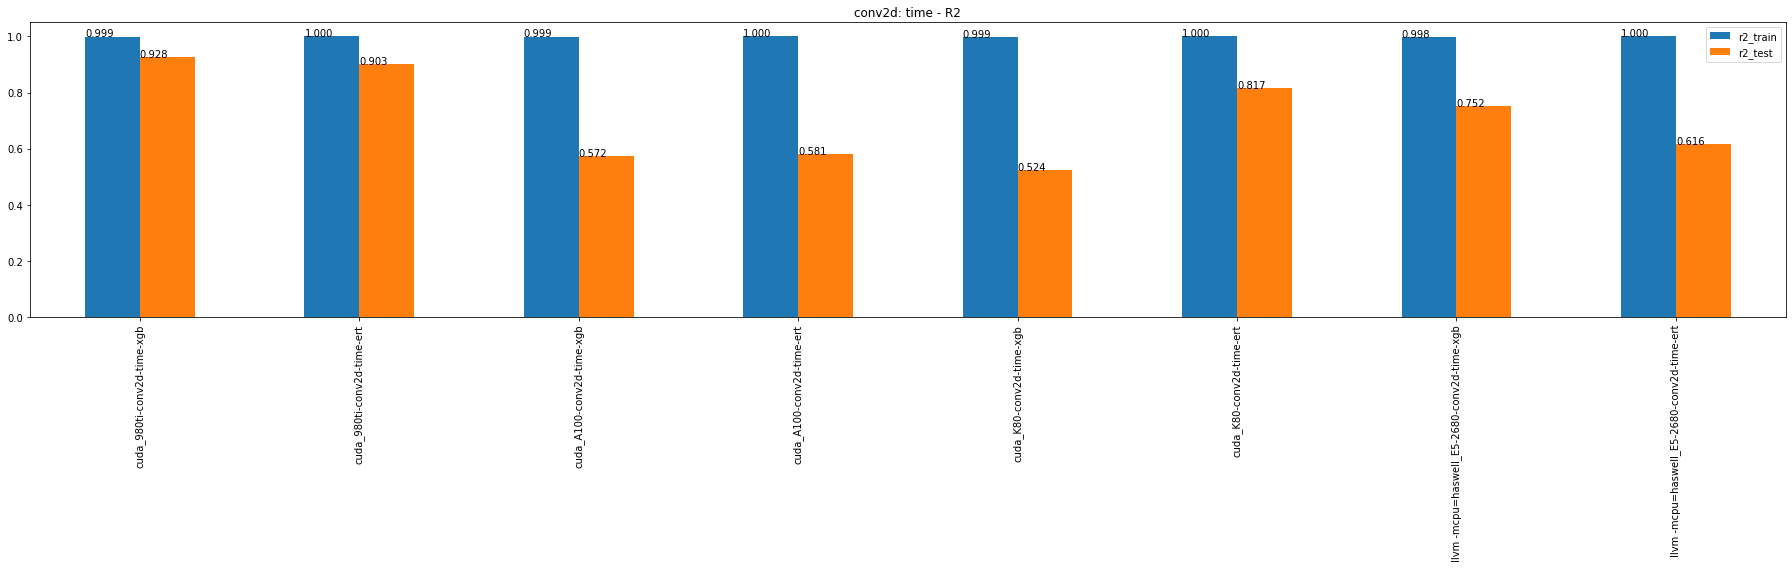

In [11]:
import matplotlib.pyplot as plt
from decimal import Decimal
plt.rcParams["figure.figsize"] = (25,8)
axes = df_r2.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - R2")
plt.tight_layout()
plt.show()

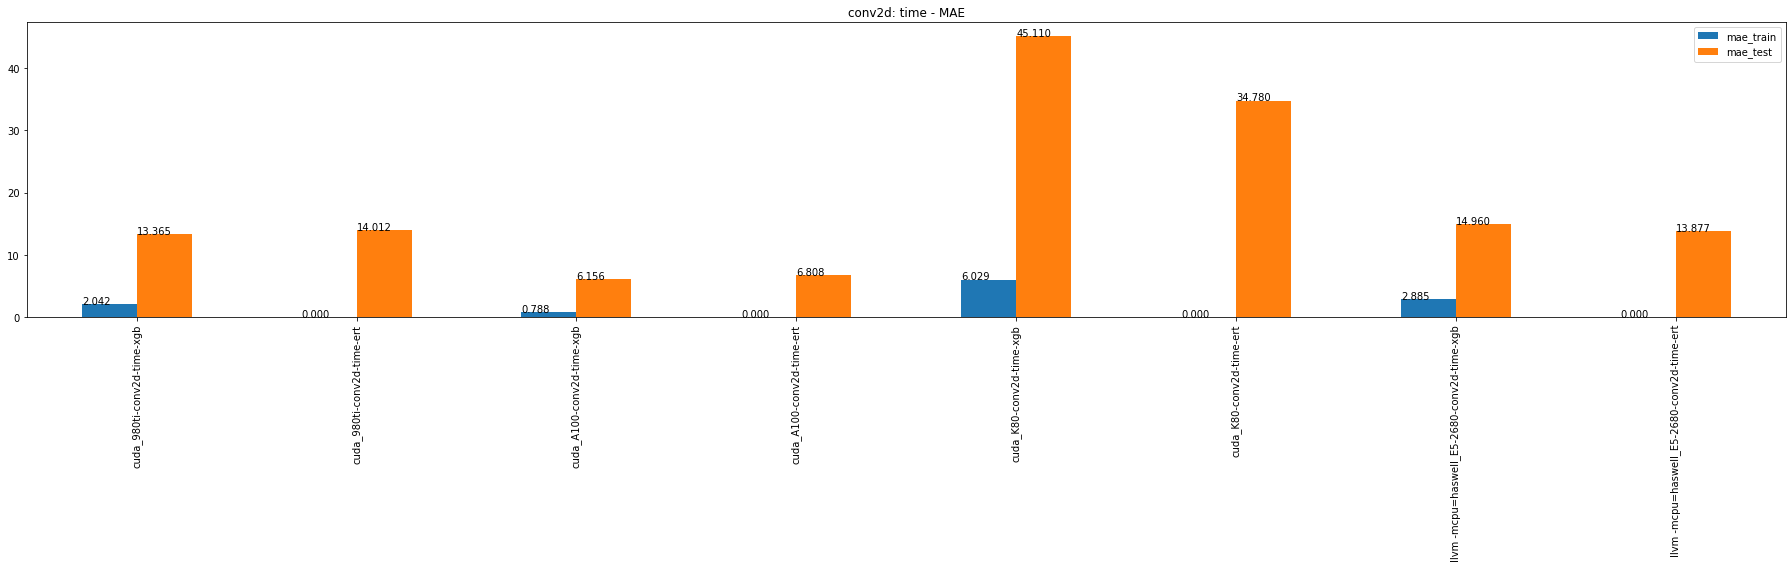

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_mae.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - MAE")
plt.tight_layout()
plt.show()

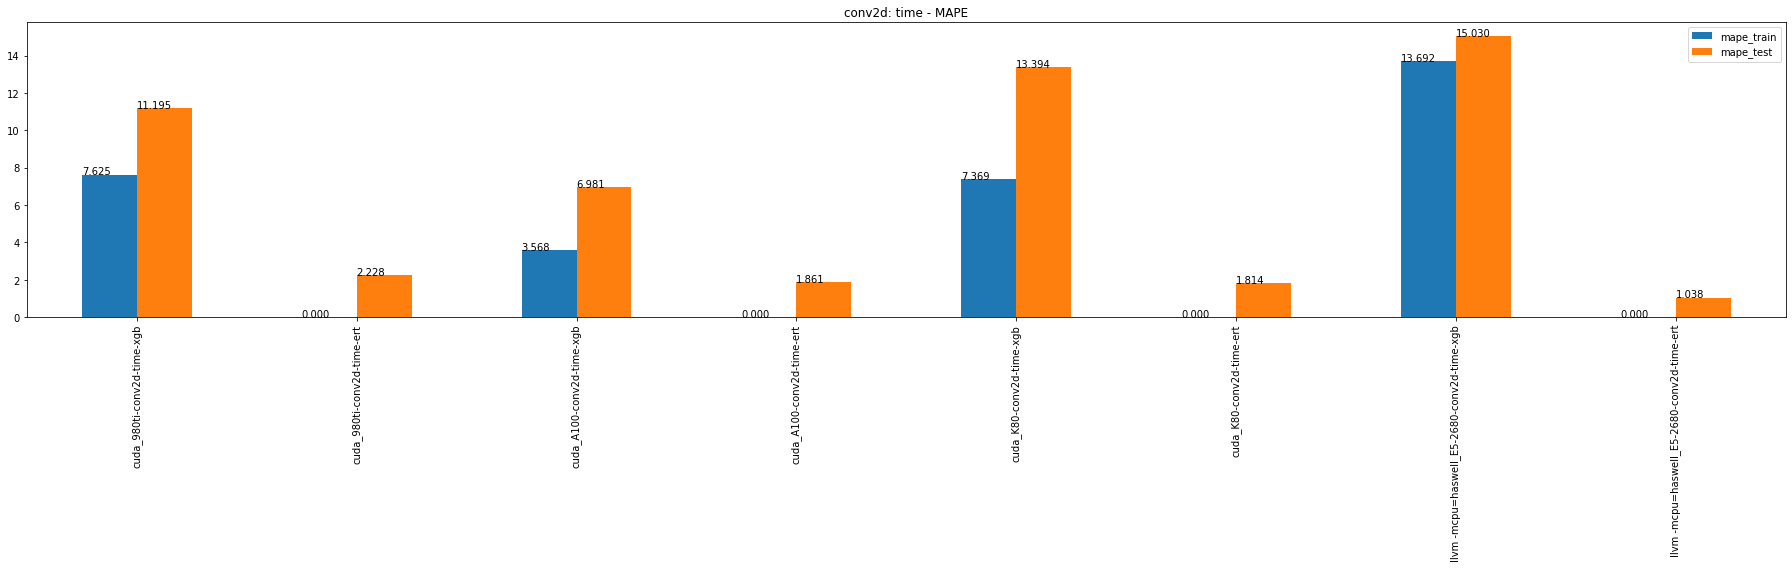

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_mape.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - MAPE")
plt.tight_layout()
plt.show()

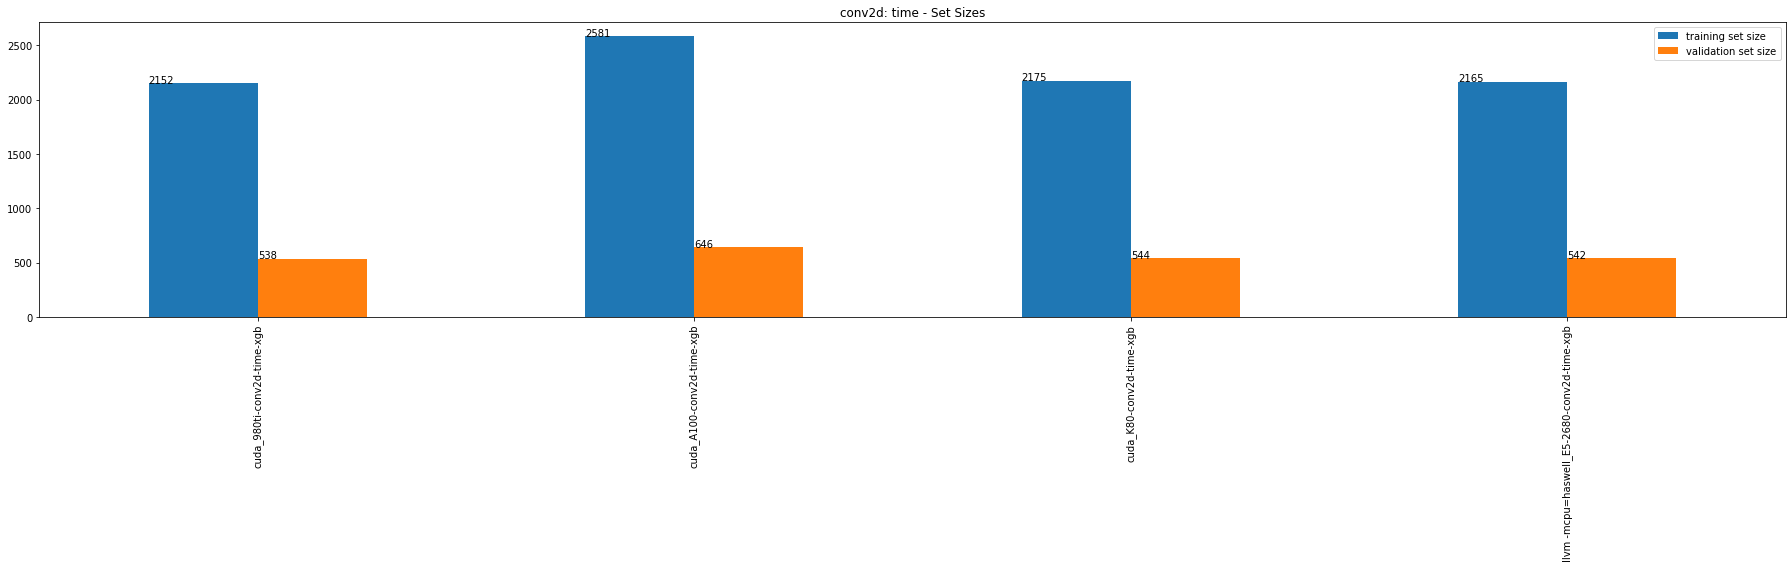

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_sets.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate(p.get_height(), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - Set Sizes")
plt.tight_layout()
plt.show()

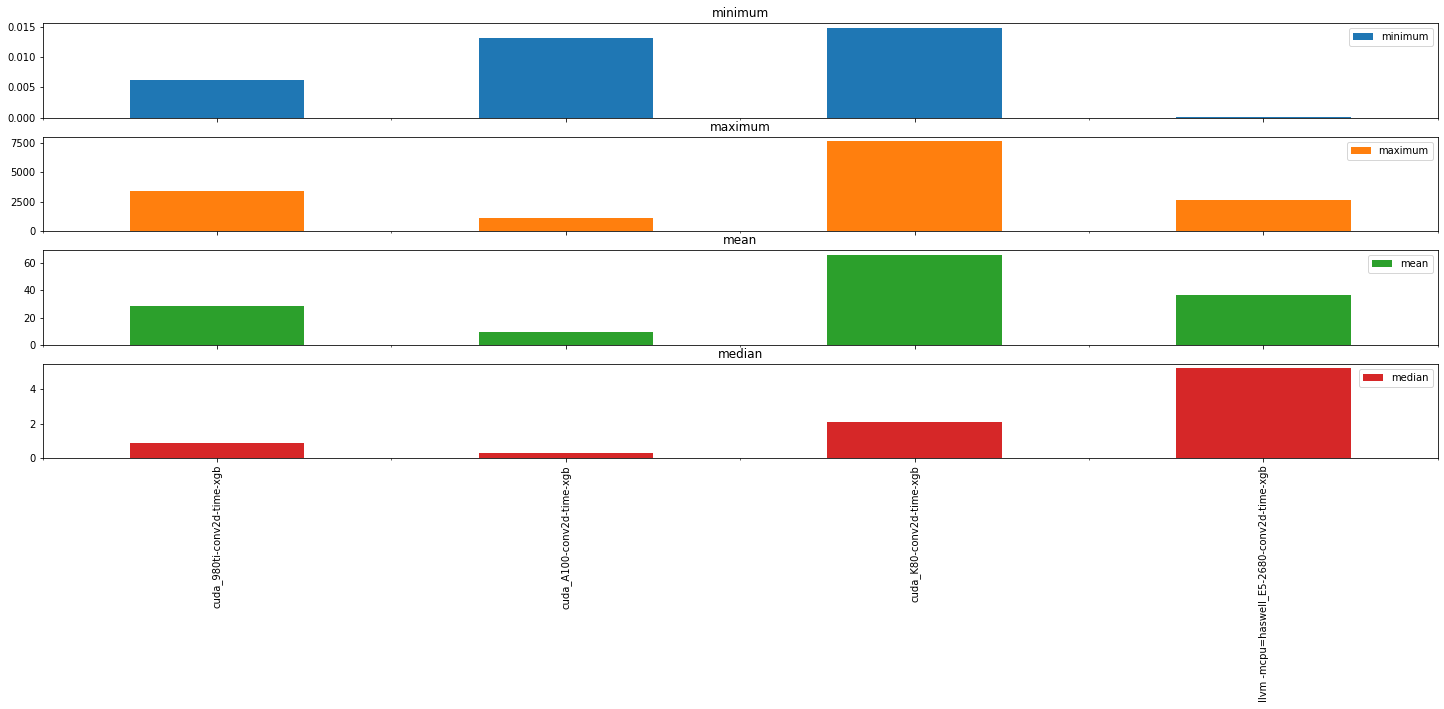

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_stats.plot.bar(subplots=True)
#plt.tight_layout()
plt.show()

In [16]:
df_stats

,device,workload,metric,minimum,maximum,mean,median
cuda_980ti-conv2d-time-xgb,cuda_980ti,conv2d,time,0.006188,3395.59,28.517599,0.864422
cuda_A100-conv2d-time-xgb,cuda_A100,conv2d,time,0.013117,1139.32,8.964296,0.293837
cuda_K80-conv2d-time-xgb,cuda_K80,conv2d,time,0.014826,7643.49,66.447504,2.074740
llvm -mcpu=haswell_E5-2680-conv2d-time-xgb,llvm -mcpu=haswell_E5-2680,conv2d,time,0.000168,2659.14,36.633232,5.239540
